# Project 2 - Ames Housing Data
## Data Cleaning and Exploratory Data Analysis

*Author: Grace Campbell*

> - Next Notebook: [Feature Engineering and Model Selection](Project-2-Feature-Engineering.ipynb)
___

## Problem Statement

I have been given data from the Ames Housing Dataset, which according to the data description "...contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010." I want to know which features of a property have the greatest effect on the price of the property at sale, and then be able to predict the price of a house based on those features.


For the entire data description, click here: http://bit.ly/2FcUzsc

#### Note:
This project is part of a competition on Kaggle. This data has two parts: a training set, on which I will be performing explanatory analysis and fitting my model, and a final hold-out test set. I only have access to the explanatory variable data for the test set; I do not know the values for the target variable. I will find out the final performance of my model on the test set when I submit its predictions to Kaggle.

### Training Dataset Cleaning

In [1741]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./datasets/train.csv', keep_default_na=False)
df.drop(['Id', 'PID'], axis=1, inplace=True)

In [1742]:
# Checking for nulls
df.isnull().sum().sum()

0

In [1743]:
# Checking the number of rows/columns in the data
df.shape

(2051, 79)

In [1744]:
# Looking at the first five rows of the data
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,60,RL,,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,60,RL,43,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,20,RL,68,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,60,RL,73,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,50,RL,82,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,3,2010,WD,138500


In [1745]:
# Looking at column data type totals
df.dtypes.value_counts()

object    53
int64     26
dtype: int64

Some of the columns have numeric data but are listed as object columns, most likely because the numbers are actually casted as strings. Let's find out what columns those are and change the values to integers.

In [1746]:
# Checking for numeric strings inside the object-type columns, and putting those columns in a list
numeric_object_cols = []

for col in df.select_dtypes(include=object).columns:
    if df[col].str.isnumeric().any() == True:
        numeric_object_cols.append(col)

In [1747]:
# Defining a function to cast these columns to int
def to_integer(col_list, df):
    for col in col_list:
        df[col] = df[col].map(lambda x: int(x) if x.isdigit() else 0)

# Calling the function
to_integer(numeric_object_cols, df)

# Confirming it worked
df[numeric_object_cols].dtypes

Lot Frontage      int64
Mas Vnr Area      int64
BsmtFin SF 1      int64
BsmtFin SF 2      int64
Bsmt Unf SF       int64
Total Bsmt SF     int64
Bsmt Full Bath    int64
Bsmt Half Bath    int64
Garage Yr Blt     int64
Garage Cars       int64
Garage Area       int64
dtype: object

### Handling Ordinal Variables

Many of these non-numeric object columns actually have ordinal values that are the same across columns, most commonly:


       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       
or some variation on that theme. Since these values have an inherent order ascribed to them, I want to map each "quality" value to a number. I will also map 'NA' (meaning that feature does not exist on the property) to 0.

For each variable in the data set which the data dictionary describes as "Ordinal," I am going to create a dictionary that maps ordinal values to their corresponding numeric values.

In [1748]:
# Instantiating empty dictionary
ordinal_dict = {}

# Defining function to map keys to a certain numeric value from 0-6 (determined from data dictionary)
def ordinal_nums(keys_list):
    i = 0
    while i < 7:
        for key_list in keys_list:
            for key in key_list:
                ordinal_dict[key] = i
            i += 1

# Each list of keys maps to one value
keys_list = [['NA', 'N', 'Mix', 'Sal'], ['Unf', 'Sev', 'IR3', 'P', 'ELO', 'MnWw', 'No', 'FuseP', 'Po', 'Y'], 
             ['LwQ', 'Mod', 'Maj1', 'Maj2', 'IR2', 'NoSeWa', 'GdWo', 'FuseF', 'RFn', 'Mn', 'Fa'],
             ['Rec', 'Gtl', 'Mod', 'NoSewr', 'FuseA', 'IR1', 'MnPrv', 'Fin', 'Av', 'TA'],
             ['Reg', 'Min1', 'Min2', 'SBrkr', 'BLQ', 'GdPrv', 'AllPub', 'Gd'], ['Ex', 'Typ', 'ALQ'], ['GLQ']]

ordinal_nums(keys_list)
ordinal_dict.values()

dict_values([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6])

In [1749]:
# Putting every ordinal column in a list (found in data dictionary)
ordinal_cols = ['Lot Shape', 'Utilities', 'Land Slope', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 
                'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 
                'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence']

# Mapping the dictionary to the columns
for column in ordinal_cols:
    df[column] = df[column].map(ordinal_dict).fillna(0)

# Changing any remaining floats to ints
df.loc[:, df.dtypes == float] = df.loc[:, df.dtypes == float].astype(np.int64)

# Checking to make sure it worked
df.dtypes.value_counts()

int64     58
object    21
dtype: int64

In [1750]:
# Saving this new cleaned data as a .csv file
df.to_csv('./datasets/train_cleaned.csv')

# Test Data

In [1751]:
df_test = pd.read_csv('./datasets/test.csv', keep_default_na=False)

In [1752]:
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD


In order for my model to also work on the holdout test set, I need to clean the data in the same way as I did the above training set.

In [1753]:
# Changing numeric object columns to int columns:
numeric_object_cols = []

for col in df_test.select_dtypes(include=object).columns:
    if df_test[col].str.isnumeric().any() == True:
        numeric_object_cols.append(col)

to_integer(numeric_object_cols, df_test)

In [1754]:
# Mapping the ordinal_dict to ordinal columns
for column in ordinal_cols:
    df_test[column] = df_test[column].map(ordinal_dict).fillna(0)

# Changing remaining floats to ints, as above
df_test.loc[:, df_test.dtypes == float] = df_test.loc[:, df_test.dtypes == float].astype(np.int64)

In [1755]:
# Saving cleaned data as a .csv file
df_test.to_csv('./datasets/test_cleaned.csv')

# Exploratory Data Analysis

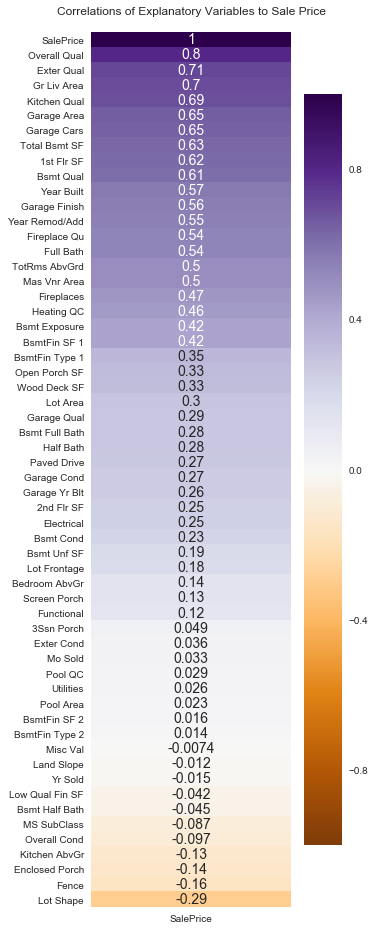

In [1696]:
plt.figure(figsize=(4,15))
sns.heatmap(df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False),
           vmin=-1,
           vmax=1,
           annot=True,
           cmap='PuOr')
plt.title('Correlations of Explanatory Variables to Sale Price\n');

It looks like `Overall Qual` has the highest correlation with `SalePrice`, at $r = 0.8$. There are 9 total variables here that have a correlation with `SalePrice` of over $r = 0.6$, which is a relatively high correlation.

## Visualization

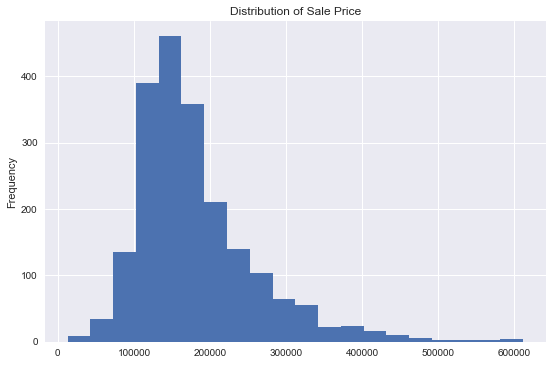

In [1759]:
# Looking at the distribution of 'SalePrice'
ax = df['SalePrice'].plot(kind='hist', bins=20)
ax.set_title('Distribution of Sale Price');

Our target variable, `SalePrice`, has a positive skew. I will want to log-transform `y` before modeling.

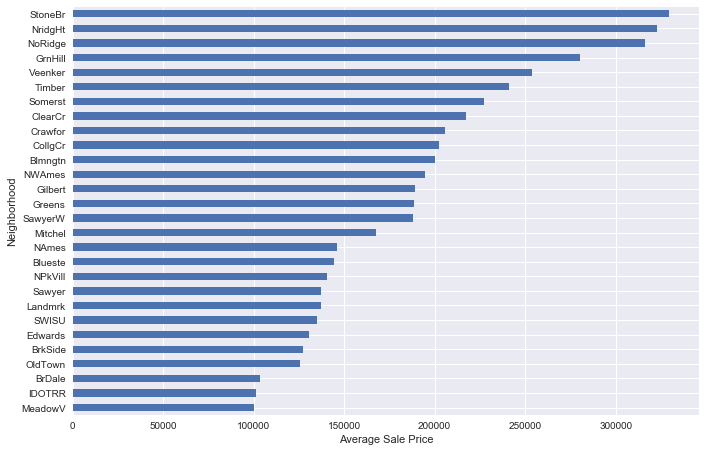

In [1802]:
# Looking at the average sale price by neighborhood
ax = df.groupby('Neighborhood')['SalePrice'].mean().sort_values().plot(kind='barh', figsize=(10, 7));
ax.set_xlabel('Average Sale Price');

This is a chart of the average sale price of a property grouped by Neighborhood. As we can see, there appears to be a marked difference in the average price of houses between neighborhoods. The neighborhood with the highest average price is over \$300,000, and the neighborhood with the lowest average price is \$100,000.

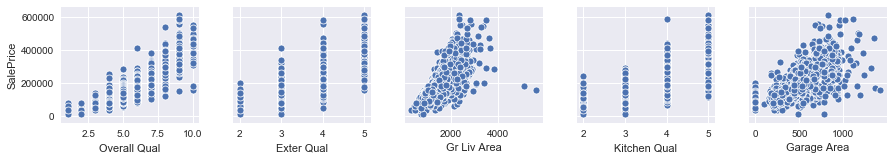

In [1778]:
# Looking at the relationship between 'SalePrice' and the most correlated numeric variables
sns.pairplot(df, y_vars = ['SalePrice'], x_vars = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Garage Area']);

Looking at scatterplots comparing `SalePrice` with the top 5 most correlated variables shows some interesting patterns. Although these variables do have a correlation with `SalePrice`, the relationship may not be exactly linear. We may benefit from performing some feature transformation to better capture the variables' relationship with `SalePrice`.

There are also some variables which may have a linear relationship with one another. For instance, `Garage Area` and `Garage Cars` are inherently related; the larger a garage is, the more cars it can hold, and vice versa. I will create interaction terms for variables like these before modeling.

I suspect that the variables `Year Built` and `Year Remod/Add` will have a strong linear relationship because, according to the data description, if the property has not had any additions, then the values will be the same for `Year Built` and `Year Remod/Add`. I will illustrate this relationship below:

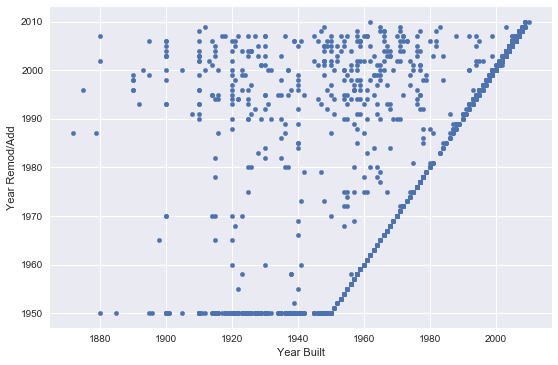

In [1777]:
df.plot(kind='scatter', x='Year Built', y='Year Remod/Add');

As expected, although there are quite a few data points which do not fall on the line, there is indeed a very strong linear relationship between these two variables that should not be ignored. I will be sure to include an interaction term of these two variables in my final model.

#### Click [here](Project-2-Feature-Engineering.ipynb) to view the next notebook, where I transform features and do preliminary modeling.

___